In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import time
import os
import sys
import math

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [26]:
ROOT_DIR = '/data/datasets/digit-recognizer/'
TRAIN_FILE_NAME = 'train.csv'
TEST_FILE_NAME = 'test.csv'
np.random.seed(42)
OUTPUT = []

def out_put():
    with open('output.csv', 'w') as f:
        f.write('ImageId,Label\n')
        for idx, val in enumerate(OUTPUT):
            f.write("{},{}\n".format(idx+1, val))
        print('over')        

In [3]:
data = pd.read_csv(os.path.join(ROOT_DIR, TRAIN_FILE_NAME))
test = pd.read_csv(os.path.join(ROOT_DIR, TEST_FILE_NAME)).values

In [4]:
DATA_SIZE, _ = data.shape
MASK = np.random.permutation(DATA_SIZE)
VAL_SIZE = 1000

## some info

### data.dtypes all int64
### data.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
### data.values:

### type numpy.ndarray, dtype('int64'), shape=(42000, 785)

In [5]:
TRAIN_DATA = data.loc[MASK[VAL_SIZE:]]
VAL_DATA = data.loc[MASK[:VAL_SIZE]]
print(TRAIN_DATA.shape, VAL_DATA.shape)

(41000, 785) (1000, 785)


In [6]:
def data_label_split(data, column_name):
    labels = data.pop(column_name)
    return data, labels

In [7]:
X_train, y_train = data_label_split(TRAIN_DATA, 'label')
X_val, y_val = data_label_split(VAL_DATA, 'label')
print('X_train.shape:',X_train.shape, 'y_train.shape:', y_train.shape)
print('X_val.shape:', X_val.shape, 'y_val.shape:', y_val.shape)

X_train.shape: (41000, 784) y_train.shape: (41000,)
X_val.shape: (1000, 784) y_val.shape: (1000,)


In [8]:
X_train, y_train = X_train.values, y_train.values

In [9]:
# scale the data
# add the epsilon to avoid devide zero
scale_x_train = (X_train - np.mean(X_train, axis=0)) / np.sqrt(np.std(X_train, axis=0)+ 1e-5)
scale_x_val = (X_val - np.mean(X_train, axis=0)) / np.sqrt(np.std(X_train, axis=0) + 1e-5)

## First implement a 2 layer NN

##### in training, we had got over 90% accuracy,
##### but in kaggle, this test accuracy was 0.83928 
##### obiviously the model was overfitting
##### so after trying this, we'll try some complex model with some regularization methods

training
Iteration 0: with minibatch training loss = 11.6 and accuracy of 0.12
Iteration 100: with minibatch training loss = 0.651 and accuracy of 0.91
Iteration 200: with minibatch training loss = 1.19 and accuracy of 0.92
Iteration 300: with minibatch training loss = 2.36 and accuracy of 0.92
Iteration 400: with minibatch training loss = 1.54 and accuracy of 0.92
Iteration 500: with minibatch training loss = 0.594 and accuracy of 0.92
Iteration 600: with minibatch training loss = 1.09 and accuracy of 0.97
Epoch 1, Overall loss = 0.984 and accuracy of 0.916


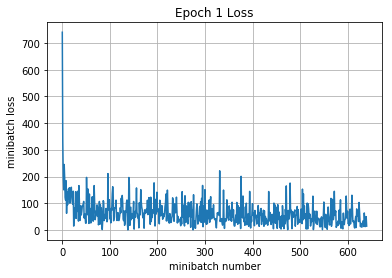

validation
Overall loss = 0.0139 and accuracy of 0.943
testing


In [20]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 28*28], name='X')
y = tf.placeholder(tf.int64, shape=None, name='y')
is_training = tf.placeholder(tf.bool)

#### start build layer now
fc_1 = tf.layers.dense(X, 1024, 
                      activation=tf.nn.relu,
                      kernel_initializer=tf.contrib.layers.xavier_initializer(),
                      name='FC1')
y_out = tf.layers.dense(fc_1, 10, 
                       activation=None,
                       name='Y_OUT')

total_losses = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
#total_losses = tf.nn.softmax_cross_entropy_with_logits(logits=y_out, labels=y)

mean_loss = tf.reduce_mean(total_losses)

optimizer = tf.train.AdamOptimizer()
train_step = optimizer.minimize(mean_loss)

correct_predictions = tf.equal(tf.argmax(y_out, axis=1), y)
accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))

variables = [mean_loss, accuracy, correct_predictions, train_step]

batch_size = 64
epochs = 1
iter_cnt = 0
N = scale_x_train.shape[0]
with tf.Session() as sess:
    print('training')
    init = tf.global_variables_initializer()
    sess.run(init)

    for e in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        correct = 0
        losses = []
        for i in range(int(math.ceil(N / batch_size))):
            mask = indices[i*batch_size : (i+1)*batch_size]
            feed_dict = {
                X: scale_x_train[mask],
                y: y_train[mask],
            }
            actual_batch_size = len(mask)
            loss, acc, corr, _ = sess.run(variables, feed_dict=feed_dict)
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            if (iter_cnt % 100) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/N
        total_loss = np.sum(losses)/N
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if True:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    print('validation')
    val_variables = [total_losses, correct_predictions]
    total_loss = 0
    total_correct = 0
    for i in range(int(math.ceil(scale_x_val.shape[0]/batch_size))):
        feed_dict = {
            X:scale_x_val[i*batch_size:(i+1)*batch_size],
            y:y_val[i*batch_size:(i+1)*batch_size]
        }
        actual_batch_size = y_val[i*batch_size:(i+1)*batch_size].shape[0]
        loss, acc = sess.run(val_variables, feed_dict=feed_dict)
        total_loss += loss
        total_correct += np.sum(acc)
    total_loss /= scale_x_val.shape[0]
    total_correct /= scale_x_val.shape[0]
    print("Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct))
    print('testing')
    val_variables = [y_out]
    for i in range(int(math.ceil(test.shape[0]/batch_size))):
        feed_dict = {
            X:test[i*batch_size:(i+1)*batch_size],
        }
        ## return a list
        out = sess.run(val_variables, feed_dict=feed_dict)
        OUTPUT.extend(list(np.argmax(out[0], axis=1)))

although we got the loss and accuracy in train data, <br>
but without a class or model , we had to train again on test data <br>
which cost a mount of computation